# Perfect-model predictability Module Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

# What's a perfect-model framework simulation?

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

How does it look like?
[See 4.2](#timeseries)

---

Some papers including perfect-model simulations:
- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

---
**This demo:**

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability:
 - DPP
 - variance-weighted mean period
 - decorrelation time
---

In [111]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model, PM_sig, 
                                 xr_predictability_horizon, DPP, 
                                 generate_damped_persistence_forecast, 
                                 PM_compute_damped_persistence, compute_persistence)
from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr)
%matplotlib inline

# How to analyze a perfect-model framework simulation?

In [112]:
print(cp.prediction.__doc__)


Objects dealing with decadal prediction metrics.

Concept of calculating predictability skill
-------------------------------------------
- metric: how is skill calculated, e.g. pearson_r, rmse
- comparison: how forecasts and observation/truth are compared, e.g., m2m, e2r

High-level functions
-------------------
- compute_perfect_model: computes the perfect-model predictability skill
according to metric and comparison
- compute_reference: computes predictability/skill relative to some reference
- compute_persistence: computes a persistence forecast from some simulation
- bootstrap from uninitialized ensemble:
    - PM_sig(ds, control, metric=rmse, comparison=_m2m, bootstrap=500, sig=99)
    - threshold to determine predictability horizon

Metrics (submit to functions as strings)
-------
- mse: Mean Square Error
- nev: Normalized Ensemble Variance
- msss: Mean Square Skill Score = ppp: Prognostic Potential Predictability
- rmse and rmse_v: Root-Mean Square Error
- nrmse: Normalized Ro

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **ensemble**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [113]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

### How does a perfect-model framework simulation look like?

<a id='timeseries'></a>

In [114]:
ignore_ens = [3023, 3124, 3139, 3178, 3237]
def plot_timeseries(ds, control, varname, ignore=True, ax=False, ens_color='black'):
    fig, ax = plt.subplots(figsize=(20, 5))

    # plot control
    control = control[varname].to_series()
    control.plot(color='black', alpha=.75, label='control', ax=ax)
    ax.axhline(control.mean(), color='blue', alpha=.1)
    
    # plot ens, ensmean, vertical lines
    for ens in ds.ensemble.values:
        if ignore and ens in ignore_ens:
            continue
        df = ds.sel(ensemble=ens).to_dataframe().unstack(level=0)[varname].T
        df[0] = control.loc[ens - 1]
        df = df.T.sort_index(axis=0)
        df.index = np.arange(ens - 1, ens - 1 + df.index.size)
        df.plot(ax=ax, color=ens_color, alpha=.2,
                label='ensemble members', legend=None)
        df.mean(axis=1).plot(ax=ax, color=ens_color,
                             linewidth=3, alpha=.95, label='ens mean')
        ax.axvline(x=ens - 1, color='black', alpha=.2, linestyle='--')

    plt.title('Timeline ' + varname + ' ' + area + ' ' + period)

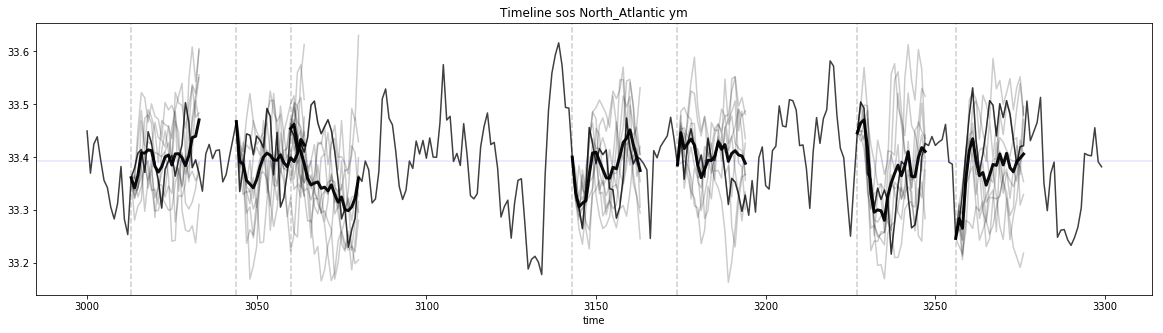

In [115]:
plot_timeseries(ds.sel(area=area,period=period),control.sel(area=area,period=period),varname)

# 1-dimensional

### Choose predictability metric and comparison

In [61]:
metric='pearson_r'
comparison='m2m'
sig=99
bootstrap=100

In [62]:
def get_limit_sig(metric='pearson_r',sig=sig):
    if metric in ['pearson_r', 'PPP', 'PM_MSSS']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

limit, sigl = get_limit_sig(metric=metric, sig=sig)

### Choose varname, area, period

In [63]:
varname='tos'
area='North_Atlantic'
period='ym'

In [64]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

## skill score against damped persistence

In [69]:
persistence_skill = compute_persistence(control_, nlags=ds_.time.size,metric=metric, dim='time')

skill = compute_perfect_model(ds_, control_, metric=metric, comparison=comparison)
threshold =  PM_sig(ds_, control_, metric=metric, comparison=comparison, sig=sigl, bootstrap=bootstrap)

ph = xr_predictability_horizon(skill, threshold, limit=limit).values

skill.plot(label=metric+' skill score')
plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
persistence_skill.plot(ls='--',c='k',label='persistence')
plt.legend()

## Comparison of metrics

Text(0.5, 1.0, 'tos North_Atlantic ym Different Metrics m2e')

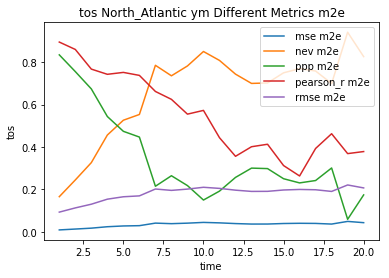

In [77]:
c = 'm2e'
for metric in ['mse', 'nev', 'ppp', 'pearson_r', 'rmse']:
    compute_perfect_model(ds_,control_,metric=metric,comparison=c).plot(label=' '+metric+' '+c)
plt.legend()
plt.title(' '.join((varname,area,period,'Different Metrics',c)))

# 3-dimensional

## 3-dimensional output
Data is stored on curvilinear grid: lon(y, x), lat(y, x)

In [6]:
ds3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds3d.nc')
control3d = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control3d.nc')

## Choose predictability metric and comparison

In [80]:
metric='pearson_r'
comparison='m2e'
sig=99
bootstrap=100
limit, sigl = get_limit_sig(metric=metric, sig=sig)

## Skill for Lead Year

In [82]:
skill3d = compute_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison)

skill3d.plot(robust=True,yincrease=False, col='time')

## Bootstrapped threshold

In [84]:
threshold3d = PM_sig(ds[varname], control3d[varname], metric=metric, comparison=comparison, 
                     sig=sigl, bootstrap=bootstrap)

threshold3d.plot(robust=True,yincrease=False)

## Predictability Horizon map

In [85]:
if limit == 'upper':
    masked3d = skill3d.where(skill3d > threshold3d)
elif limit == 'lower':
    masked3d = skill3d.where(skill3d < threshold3d)

Text(0.5, 0.98, 'Skill score if above threshold')

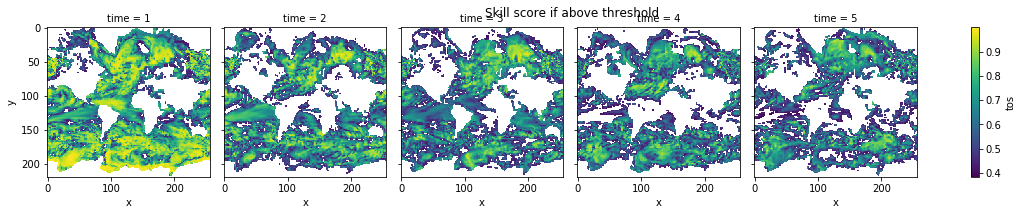

In [86]:
masked3d.plot(yincrease=False, col='time')
plt.suptitle('Skill score if above threshold')

In [88]:
ph3d = xr_predictability_horizon(masked3d, threshold3d, limit=limit)
ph3d.name = 'Lead Years'

ph3d.where(ph3d>0).plot(robust=False,yincrease=False)
plt.title('Predictability Horizon '+varname)

## Persistence
Plot skill where larger than persistence.

In [95]:
varname='sos'
persistence_skill3d = compute_persistence(control3d[varname], nlags=ds3d.time.size,metric=metric, dim='time').rename({'lead time':'time'})
beat_persistence = skill3d.where(skill3d>persistence_skill3d)
beat_persistence.plot(col='time',yincrease=False)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances of predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [40]:
help(DPP)

Help on function DPP in module climpred.prediction:

DPP(ds, m=10, chunk=True, var_all_e=False)
    Calculate Diagnostic Potential Predictability (DPP) as potentially
    predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Different way of calculating it than in Seferian 2018 or
    Resplandy 2015, but quite similar results.
    
    References
    ----------
    - Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    - Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    - Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the
        Decadal Predictability of Land and Ocean Carbon Uptake.

### Resplandy 2015, Seferian 2018 method

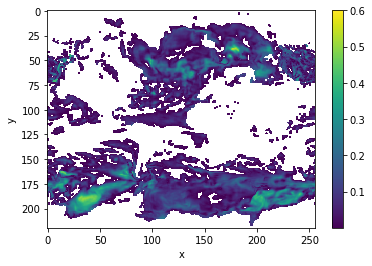

In [41]:
DPP10 = DPP(control3d[varname], m=10, chunk=False)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

### Original Boer 2004 implementation

/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


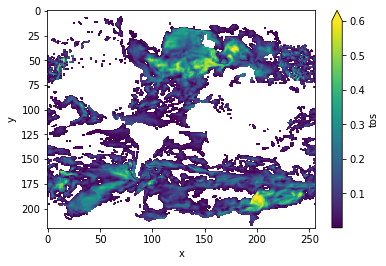

In [42]:
DPP10 = DPP(control3d[varname], m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

yields similar results

## varweigthed mean period

In [43]:
help(xr_varweighted_mean_period)

Help on function xr_varweighted_mean_period in module climpred.stats:

xr_varweighted_mean_period(ds, time_dim='time')
    Calculate the variance weighted mean period of an xr.DataArray.
    
    Reference
    ---------
    - Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal
      Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27,
      2010): 6292-6311. https://doi.org/10/bwq92h.



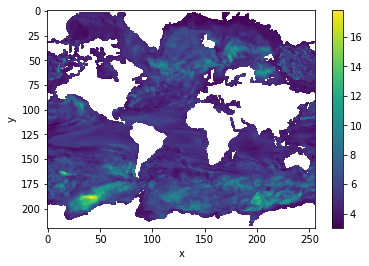

In [47]:
from climpred.stats import xr_varweighted_mean_period as xvmp
varweighted_mean_period = xvmp(control3d[varname],time_dim='time')
varweighted_mean_period.plot(yincrease=False)

## Lag1 autocorrelation

In [48]:
help(xr_autocorr)

Help on function xr_autocorr in module climpred.stats:

xr_autocorr(ds, lag=1, dim='time', return_p=False)
    Calculated lagged correlation of a xr.Dataset.
    
    Parameters
    ----------
    ds : xarray dataset/dataarray
    lag : int (default 1)
        number of time steps to lag correlate.
    dim : str (default 'time')
        name of time dimension/dimension to autocorrelate over
    return_p : boolean (default False)
        if false, return just the correlation coefficient.
        if true, return both the correlation coefficient and p-value.
    
    Returns
    -------
    r : Pearson correlation coefficient
    p : (if return_p True) p-value



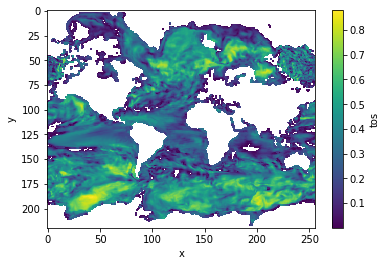

In [49]:
corr_ef = xr_autocorr(control3d[varname],dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [50]:
help(xr_decorrelation_time)

Help on function xr_decorrelation_time in module climpred.stats:

xr_decorrelation_time(da, r=20, dim='time')
    Calculate decorrelation time of an xr.DataArray.
    
    tau_d = 1 + 2 * sum_{k=1}^(infinity)(alpha_k)**k
    
    Parameters
    ----------
    da : xarray object
    r : int (default 20)
        Number of iterations to run of the above formula
    dim : str (default 'time')
        Time dimension for xarray object
    
    Reference
    ---------
    - Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
    Research. Cambridge ; New York: Cambridge University Press, 1999., p.373



/Users/ribr5703/anaconda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


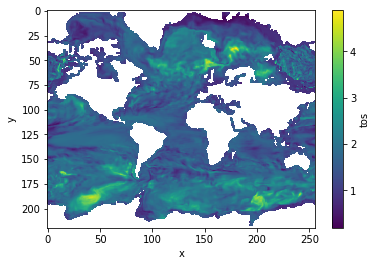

In [51]:
decorr_time = xr_decorrelation_time(control3d[varname])
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)